In [1]:
# num_words=10000 means you'll only keep the top 10,000 most frequently occurring words in the training data
# discarding rare words allows us to work with vectors of manageable size
# if we didnt set this limit, we'd be working with 88,585 unique words
# rare words only occur in a few examples, and thus can't be meaningfully used for classification


from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training and test data format

# variables train_data and test_data are lists of reviews
# each review is a list of word indices (encoding a sequence of words)
# train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive

In [2]:
print(f"first training example has {len(train_data[0])} integer-encoded words")
print(f"in the first example, the first ten feature values are: {train_data[0][:10]}")

first training example has 218 integer-encoded words
in the first example, the first ten feature values are: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]


In [3]:
train_labels[0] # first review has label 1, i.e., it is positive

np.int64(1)

In [4]:
max([max(sequence) for sequence in train_data]) # check that word encoding integers are less than 10,000

9999

In [5]:
# Decoding reviews back to text

word_index = imdb.get_word_index()
list(word_index.items())[:10]

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008)]

In [6]:
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
list(reverse_word_index.items())[:10]

[(34701, 'fawn'),
 (52006, 'tsukino'),
 (52007, 'nunnery'),
 (16816, 'sonja'),
 (63951, 'vani'),
 (1408, 'woods'),
 (16115, 'spiders'),
 (2345, 'hanging'),
 (2289, 'woody'),
 (52008, 'trawling')]

In [7]:
 # offset of 3 needed because 0, 1, and 2 are reserved indices for "padding," "start of sequence," and "unknown."
decoded_review = [reverse_word_index.get(i - 3, "?") for i in train_data[0]]

print(train_data[0][:10])
print(" ".join(decoded_review[:10]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
? this film was just brilliant casting location scenery story


### Preparing the data

- can't directly feed lists of integers into NN: they all have different lengths
- need to convert lists into tensors
- there are two ways to do that:
  - Pad your lists so that they all have the same length, turn them into an integer tensor of shape `(samples, max_length)`, and start your model with a layer capable of handling such integer tensors (the `Embedding` layer, which we'll cover later).
  - *Multi-hot encode* your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[8, 5]` into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.

Let’s go with the latter solution.

In [8]:
# Encoding the integer sequences via multi-hot encoding
len(train_data)

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # initialize results to an np.array with appropriate size
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. # if word with index j found in sequence then set jth entry to 1 in multi-hot encoding
    return results
x_train = vectorize_sequences(train_data) # convert training data
x_test = vectorize_sequences(test_data)   # convert test data

In [9]:
x_train.shape

(25000, 10000)

In [10]:
x_test.shape

(25000, 10000)

In [11]:
example = np.array(train_data[0]) # list to np.array
np.unique(example[example < 10]) # which words with index < 10 occur in this example?

array([1, 2, 4, 5, 6, 7, 8, 9])

In [12]:
x_train[0][:10] # the words that occur determine where we place ones in the multi-hot encoding

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [13]:
y_train = np.array(train_labels).astype("float32")
y_test = np.array(test_labels).astype("float32")

### Building your model

- we will use a plain stack of densely connected (`Dense`) layers with `relu` activations
- two key architecture decisions to be made:
  - how many layers to use
  - how many units to choose for each layer
  
Later you'll learn formal principles to guide you in making these choices. For the time being, you'll have to trust the following architecture choices:
- two intermediate layers with 16 units each
- a third layer that will output the scalar prediction

This is what the model looks like.

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/IMDB_3_layers.png" alt="picture" height="300">

And note the similarity to the MNIST example you saw previously.

**Model definition**

- first argument being passed to each `Dense` layer is the number of units in the layer
- that's the dimensionality of representation space of the layer
- such a `Dense` layer with a `relu` activation implements the following chain of tensor operations:
```
output = relu(dot(input, W) + b)
```
- 16 units means the weight matrix `W` will have shape `(input_dimension, 16)`
- the dot (matrix) product with `W` will project the input data onto a 16-dimensional representation space
- Then the layer adds the bias vector `b` and applies the `relu` operation
- dimensionality of representation = "how much freedom you're allowing the model to have when learning internal representations"
- more units (a higher-dimensional representation space) means:
  - your model can learn more-complex representations
  - but it makes the model more computationally expensive and may lead to learning unwanted patterns (which can lead to overfitting)


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [15]:
model.compile(optimizer="rmsprop",         # good default choice for optimizer
              loss="binary_crossentropy",  # since our model outputs probabilities, cross entropy is a good choice
              metrics=["accuracy"])

### Validating your approach

- a deep learning model (or any ML model) should never be evaluated on its training data
- it’s standard practice to use a validation set to monitor the accuracy of the model during training
- we’ll create a validation set by setting apart 10,000 samples from the original training data

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

- we will now train the model for 15 epochs
- that's 15 iterations over all samples in the training data
- we will use mini-batches of 512 samples
- we will monitor loss and accuracy on the 10,000 samples that we set apart
- we do so by passing the validation data as the `validation_data` argument

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.6804 - loss: 0.6134 - val_accuracy: 0.8389 - val_loss: 0.4286
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8890 - loss: 0.3565 - val_accuracy: 0.8711 - val_loss: 0.3382
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9138 - loss: 0.2663 - val_accuracy: 0.8894 - val_loss: 0.2857
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9362 - loss: 0.2046 - val_accuracy: 0.8862 - val_loss: 0.2872
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9446 - loss: 0.1719 - val_accuracy: 0.8852 - val_loss: 0.2867
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9503 - loss: 0.1490 - val_accuracy: 0.8862 - val_loss: 0.2847
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9610 - loss: 0.1250 - val_accuracy: 0.8834 - val_loss: 0.2918
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9710 - loss: 0.1041 - val_accuracy: 0.8797 - 

In [ ]:
model.summary()

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

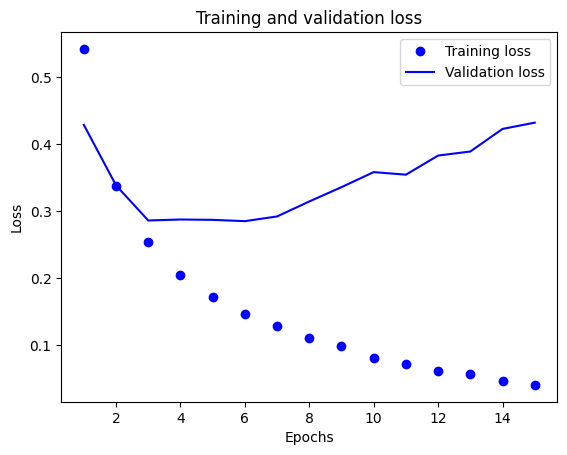

In [19]:
# Plotting the training and validation loss

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

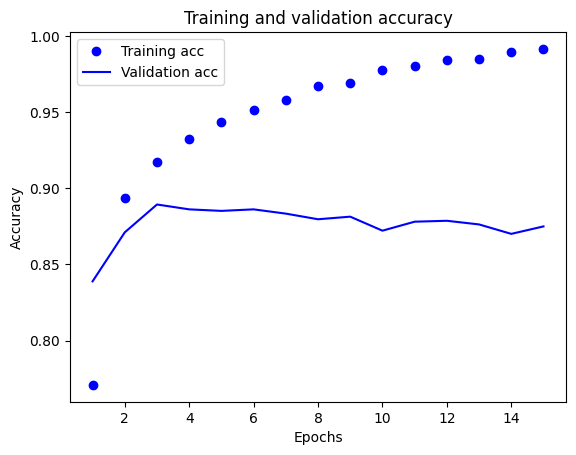

In [20]:
# Plotting the training and validation accuracy

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()